In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [93]:
d19 = pd.read_csv(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", header = 1)

d19.head()

,BookingReference,Created Date,Reference,Attendee Status,Attended
0,B739461,16/07/2019,A802512,Cancelled,NaN
1,B739462,16/07/2019,A802513,Attending,Yes
2,B739463,16/07/2019,A802514,Attending,Yes
3,B739464,16/07/2019,A802515,Attending,No
4,B739465,16/07/2019,A802516,Attending,No


In [94]:
d19.shape

(1185, 5)

In [95]:
# Aggregate the data on a weekly basis
d19["Created Date"] = pd.to_datetime(d19["Created Date"], format='%d/%m/%Y')

d19['Week'] = d19['Created Date'].dt.isocalendar().week # uses ISO calendar week starts on Monday
d19['Year'] = d19['Created Date'].dt.year
weekly_reg = d19.groupby(['Year','Week']).size()

#convert to dataframe
weekly_reg = weekly_reg.reset_index()
weekly_reg.columns = ['Year','Week', 'Total Registrations']

"""
Note that the ISO calendar uses the actual week so in this case, the date 16th July 2019 fell on week 29 of that year.

"""

'\nNote that the ISO calendar uses the actual week so in this case, the date 16th July 2019 fell on week 29 of that year.\n\n'

In [96]:
weekly_reg

,Year,Week,Total Registrations
0,2019,29,125
1,2019,31,141
2,2019,32,35
3,2019,33,15
4,2019,34,8
5,2019,35,12
6,2019,36,26
7,2019,37,16
8,2019,38,16
9,2019,39,31


In [97]:
# Calculate the Z score for the Total Registrations
weekly_reg['Z-Score'] = (weekly_reg['Total Registrations'] - weekly_reg['Total Registrations'].mean())/ weekly_reg['Total Registrations'].std()

# Binary indicator for weeks that have a Z-score greater than 1
weekly_reg['Advertisement'] = (weekly_reg['Z-Score'] > 1).astype(int)

In [98]:
weekly_reg

,Year,Week,Total Registrations,Z-Score,Advertisement
0,2019,29,125,0.921582,0
1,2019,31,141,1.170798,1
2,2019,32,35,-0.480261,0
3,2019,33,15,-0.791782,0
4,2019,34,8,-0.900814,0
5,2019,35,12,-0.838510,0
6,2019,36,26,-0.620445,0
7,2019,37,16,-0.776206,0
8,2019,38,16,-0.776206,0
9,2019,39,31,-0.542565,0


In [99]:
# Identifying weeks with missing data

# Find the first and last date in the 'Created Date' column
first_date = d19['Created Date'].min()
last_date = d19['Created Date'].max()

# Find the Monday of the week for the first date
start_of_first_week = first_date - pd.Timedelta(days=first_date.weekday())

# Find the end of the week for the last date (assuming weeks start on Monday)
end_of_last_week = last_date + pd.Timedelta(days=(6-last_date.weekday()))

complete = pd.DataFrame(pd.date_range(start=start_of_first_week, end=end_of_last_week, freq='W-MON').isocalendar().week)
complete['Year'] = pd.date_range(start=start_of_first_week, end=end_of_last_week, freq='W-MON').isocalendar().year

complete.columns = ['Week','Year']

complete_reg = pd.merge(complete, weekly_reg, on = ['Year','Week'], how = 'left')

# Replace NaN with 0
complete_reg['Total Registrations'].fillna(0, inplace = True)
complete_reg['Z-Score'].fillna(0, inplace = True)
complete_reg['Advertisement'].fillna(0, inplace = True)

In [100]:
complete_reg

,Week,Year,Total Registrations,Z-Score,Advertisement
0,29,2019,125.0,0.921582,0.0
1,30,2019,0.0,0.000000,0.0
2,31,2019,141.0,1.170798,1.0
3,32,2019,35.0,-0.480261,0.0
4,33,2019,15.0,-0.791782,0.0
5,34,2019,8.0,-0.900814,0.0
6,35,2019,12.0,-0.838510,0.0
7,36,2019,26.0,-0.620445,0.0
8,37,2019,16.0,-0.776206,0.0
9,38,2019,16.0,-0.776206,0.0


In [101]:
# Create table with date time index
#weekly_reg['Date'] = pd.to_datetime(weekly_reg['Year'].astype(str) + 'W' + weekly_reg['Week'].astype(str) + '1', format='%GW%V%u')

#data_model = weekly_reg.set_index('Date')[['Total Registrations', 'Advertisement']]

# Assuming 'weekly_reg' contains the 'Year' and 'Week' columns
weekly_reg['Date'] = pd.to_datetime(weekly_reg['Year'].astype(str) + '-' + weekly_reg['Week'].astype(str) + '-1', format='%G-%V-%u')

# Now set the 'Date' column as the datetime index
data_model = weekly_reg.set_index('Date')[['Total Registrations', 'Advertisement']]


In [102]:
data_model

,Total Registrations,Advertisement
Date,,
2019-07-15,125,0
2019-07-29,141,1
2019-08-05,35,0
2019-08-12,15,0
2019-08-19,8,0
2019-08-26,12,0
2019-09-02,26,0
2019-09-09,16,0
2019-09-16,16,0


In [103]:
# Buliding the SARIMAX model

#Split the data into train and test sets
split = int(len(data_model) * 0.8) # 80/20 split
train = data_model.iloc[:split]
test = data_model.iloc[split:]

In [104]:
# Selecting model parameters with auto arima
#auto = auto_arima(train['Total Registrations'], exogenous = train[['Advertisement']], seasonal = True, m = 15,max_D = 1, stepwise = True, trace = True)

#print(auto.summary())

In [105]:
# The model
model = SARIMAX(train['Total Registrations'],
                exog = train[['Advertisement']],
                order = (1,0,1),
                seasonal_order = (0,0,0,0),
                enforce_stationarity = False,
                enforce_invertibility = False)

fitted = model.fit()

# Forecasting
ex_variable = test[['Advertisement']]
forecast = fitted.get_forecast(steps = len(test), exog = ex_variable)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int() 

# Evaluation
rmse = np.sqrt(mean_squared_error(test['Total Registrations'], forecast_values))
print(f"RMSE: {rmse}")

RMSE: 103.65784087977164


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No suppo

In [ ]:
# Plot the forecast along with the confidence band
plt.figure(figsize=(10, 5))
plt.plot(train['Total Registrations'], label='Training Data')
plt.plot(test['Total Registrations'], label='Actual Registrations')
plt.plot(forecast_values, label='Forecasted Registrations')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', label='Confidence Interval')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'train', 'test', 'forecast_values', and 'conf_int' are already defined and have a weekly datetime index

plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Total Registrations'], label='Training Data')
plt.plot(test.index, test['Total Registrations'], label='Actual Registrations')
plt.plot(test.index, forecast_values, label='Forecasted Registrations')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

# Set the locator for the x-axis to show every week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.WeekdayLocator()))

plt.title('Weekly Registrations and Forecasts')
plt.xlabel('Week of the Year')
plt.ylabel('Total Registrations')
plt.legend()
plt.grid(visible=True)
plt.tight_layout()
plt.show()


In [108]:
# Train on daily data
#daily_reg = d19.groupby(['Created Date']).size()

daily_reg = d19.groupby('Created Date').size().reset_index(name='Total Registrations')

In [116]:
daily_reg.head()

,Created Date,Total Registrations,Z-Score,Advertisement
0,2019-07-16,125,4.418724,1
1,2019-07-30,119,4.173942,1
2,2019-07-31,19,0.094235,0
3,2019-08-01,2,-0.599315,0
4,2019-08-02,1,-0.640112,0


In [110]:
# Calculate the Z score for the Total Registrations
daily_reg['Z-Score'] = (daily_reg['Total Registrations'] - daily_reg['Total Registrations'].mean())/ daily_reg['Total Registrations'].std()

# Binary indicator for weeks that have a Z-score greater than 1
daily_reg['Advertisement'] = (daily_reg['Z-Score'] > 1).astype(int)

In [111]:
first_date = d19['Created Date'].min()
last_date = d19['Created Date'].max()

date_range = pd.DataFrame(pd.date_range(start=first_date, end=last_date), columns=['Date'])

complete_reg = pd.merge(date_range, daily_reg, left_on='Date', right_on='Created Date', how='left')

complete_reg.drop(columns=['Created Date'], inplace=True)

complete_reg['Total Registrations'].fillna(0, inplace=True)
complete_reg['Z-Score'].fillna(0, inplace=True)
complete_reg['Advertisement'].fillna(0, inplace=True)

In [115]:
complete_reg.head()

,Date,Total Registrations,Z-Score,Advertisement
0,2019-07-16,125.0,4.418724,1.0
1,2019-07-17,0.0,0.000000,0.0
2,2019-07-18,0.0,0.000000,0.0
3,2019-07-19,0.0,0.000000,0.0
4,2019-07-20,0.0,0.000000,0.0


In [118]:
#Create a datetime index
complete_reg['Date'] = pd.to_datetime(complete_reg['Date'])
complete_reg = complete_reg.set_index('Date')


In [123]:
# Build the SARIMAX model
split_point = int(len(complete_reg) * 0.8)
train_data = complete_reg.iloc[:split_point]
test_data = complete_reg.iloc[split_point:]

# Fit the model
daily_model = SARIMAX(train_data['Total Registrations'],
                exog = train_data[['Advertisement']],
                order = (1,0,1),
                seasonal_order = (0,0,0,0),
                enforce_stationarity = False,
                enforce_invertibility = False)

fitted_model = daily_model.fit()


# Forecast
exog_future = test_data[['Advertisement']]  # Include this if you have daily advertisement data
forecast = fitted_model.get_forecast(steps=len(test_data), exog=exog_future)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluation
rmse = np.sqrt(mean_squared_error(test_data['Total Registrations'], forecast_values))
print(f"RMSE: {rmse}")

RMSE: 39.74528339755598


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


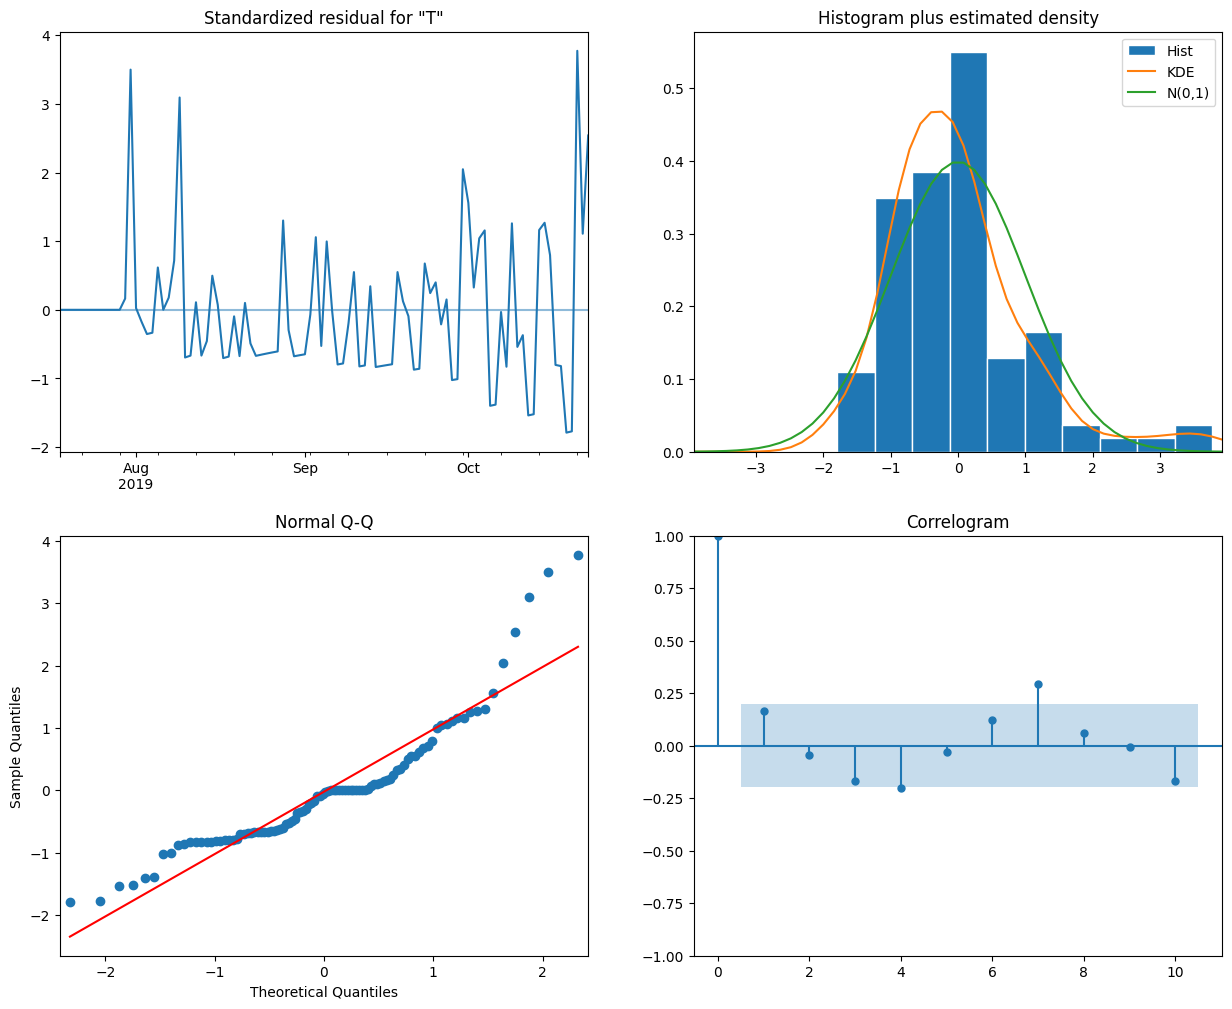

In [124]:
fitted_model.plot_diagnostics(figsize = (15,12))
plt.show()

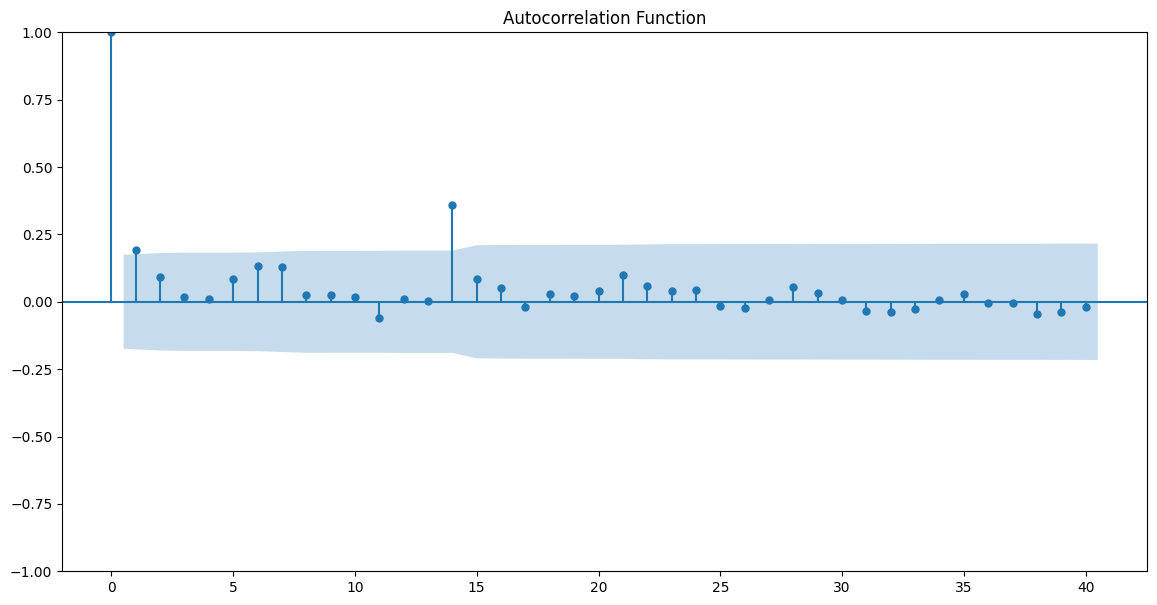

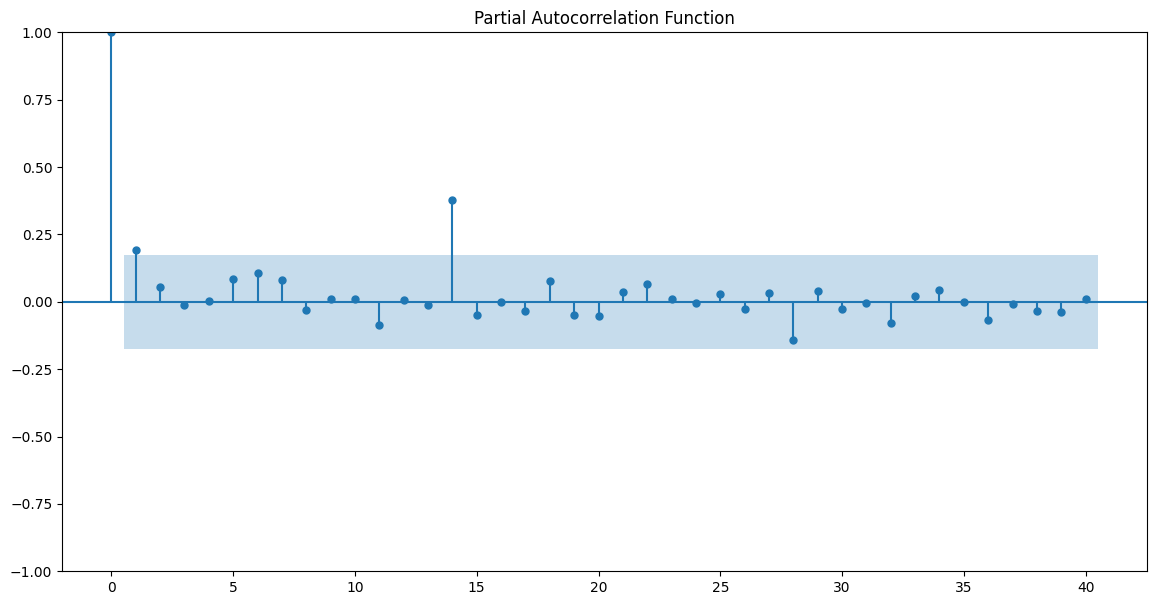

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'complete_reg' is your DataFrame and it has a column 'Total Registrations' with no missing values.

# ACF plot
plt.figure(figsize=(14, 7))
plot_acf(complete_reg['Total Registrations'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.show()

# PACF plot
plt.figure(figsize=(14, 7))
plot_pacf(complete_reg['Total Registrations'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.show()


In [126]:
import itertools

def sarimax_grid_search(y, exog, p_range, d_range, q_range, seasonal_pdq):
    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Generate all different combinations of p, d, and q triplets
    pdq = list(itertools.product(p_range, d_range, q_range))

    # Loop over all possible parameter combinations
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                # Fit the SARIMAX model
                model = SARIMAX(y,
                                exog=exog,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                model_fit = model.fit(disp=False)

                # Compare this model's AIC/BIC to the best so far
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_bic = model_fit.bic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = model_fit
            except Exception as e:
                continue

    print(f"Best SARIMAX{best_order}x{best_seasonal_order} model - AIC:{best_aic}, BIC:{best_bic}")
    return best_model

# Define the p, d, and q ranges to try
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Define the seasonal p, d, q, and seasonal_periods
# For daily data, you might want to consider a weekly seasonality of 7 days
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# Assuming `train_data` is your training dataset
# and `train_data['Advertisement']` is the exogenous variable
best_model = sarimax_grid_search(train_data['Total Registrations'],
                                 train_data[['Advertisement']],
                                 p, d, q,
                                 seasonal_pdq)

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppDa

Best SARIMAX(0, 1, 2)x(2, 1, 2, 7) model - AIC:439.04201890091605, BIC:457.5819238092065


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
# Fit the model with the best parameters
best_sarimax_model = SARIMAX(
    train_data['Total Registrations'],
    exog=train_data[['Advertisement']],
    order=(0, 1, 2),
    seasonal_order=(2, 1, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_best_model = best_sarimax_model.fit()

# Prepare the exogenous variable for the test period
exog_future = test_data[['Advertisement']]

# Forecast
forecast_results = fitted_best_model.get_forecast(steps=len(test_data), exog=exog_future)

# Get the forecast and the confidence intervals
forecast_values = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Calculate RMSE using the forecast and actual values from test_data
rmse = np.sqrt(mean_squared_error(test_data['Total Registrations'], forecast_values))
print(f"Test RMSE: {rmse}")


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Test RMSE: 39.43339695856682


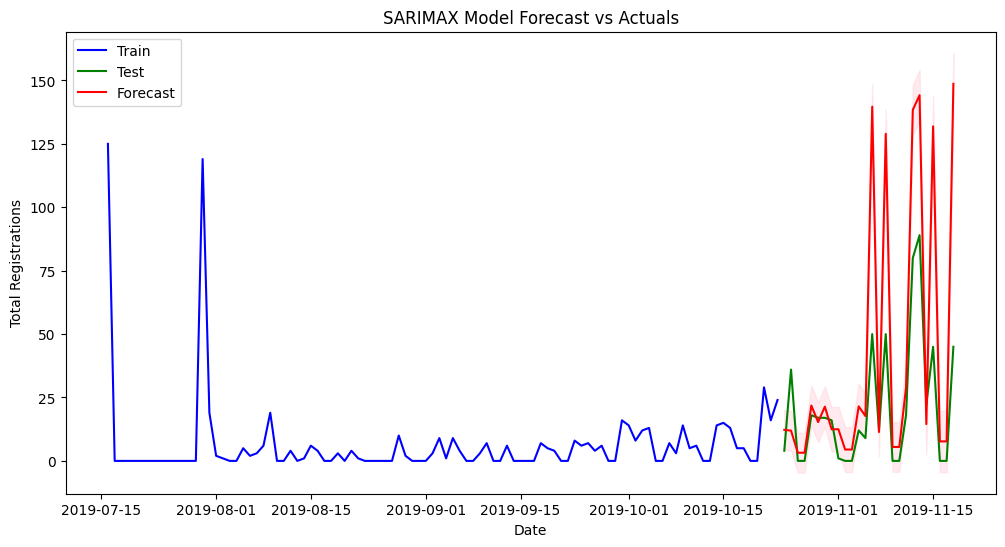

In [128]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot the observed values
plt.plot(train_data['Total Registrations'], label='Train', color='blue')
plt.plot(test_data['Total Registrations'], label='Test', color='green')

# Plot the forecasted values
plt.plot(test_data.index, forecast_values, label='Forecast', color='red')

# Plot the confidence interval
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('SARIMAX Model Forecast vs Actuals')
plt.legend()

# Show plot
plt.show()


In [113]:
'''# Group by 'Created Date' to get daily counts
daily_reg = d19.groupby(d19['Created Date'].dt.normalize()).size().reset_index(name='Total Registrations')

# Calculate the Z-score for the 'Total Registrations'
daily_reg['Z-Score'] = (daily_reg['Total Registrations'] - daily_reg['Total Registrations'].mean()) / daily_reg['Total Registrations'].std()

# Create a binary indicator for days where the Z-score is greater than 1 (assumed to be days with advertisements)
daily_reg['Advertisement'] = (daily_reg['Z-Score'] > 1).astype(int)

# Normalize the 'Created Date' to ensure it's at day precision (removes time component)
daily_reg['Created Date'] = daily_reg['Created Date'].dt.normalize()

# Create a complete date range from the start to the end of your dataset
complete_date_range = pd.date_range(start=d19['Created Date'].min(), end=d19['Created Date'].max(), freq='D')

# Create a dataframe from the complete date range
complete_daily_data = pd.DataFrame(complete_date_range, columns=['Created Date'])

# Merge the complete date range with the daily registrations data to identify missing days
daily_merged = pd.merge(complete_daily_data, daily_reg, on='Created Date', how='left')

# Fill NaN values with 0 for days without registrations and where 'Advertisement' might be NaN
daily_merged['Total Registrations'].fillna(0, inplace=True)
daily_merged['Z-Score'].fillna(0, inplace=True)
daily_merged['Advertisement'].fillna(0, inplace=True)

daily_merged.head()'''

"# Group by 'Created Date' to get daily counts\ndaily_reg = d19.groupby(d19['Created Date'].dt.normalize()).size().reset_index(name='Total Registrations')\n\n# Calculate the Z-score for the 'Total Registrations'\ndaily_reg['Z-Score'] = (daily_reg['Total Registrations'] - daily_reg['Total Registrations'].mean()) / daily_reg['Total Registrations'].std()\n\n# Create a binary indicator for days where the Z-score is greater than 1 (assumed to be days with advertisements)\ndaily_reg['Advertisement'] = (daily_reg['Z-Score'] > 1).astype(int)\n\n# Normalize the 'Created Date' to ensure it's at day precision (removes time component)\ndaily_reg['Created Date'] = daily_reg['Created Date'].dt.normalize()\n\n# Create a complete date range from the start to the end of your dataset\ncomplete_date_range = pd.date_range(start=d19['Created Date'].min(), end=d19['Created Date'].max(), freq='D')\n\n# Create a dataframe from the complete date range\ncomplete_daily_data = pd.DataFrame(complete_date_range, co

In [114]:
#daily_merged